### Autoencoder

Con FASHION-MNIST construir un autoencoder (utilizar la base de datos como entrenamiento/validación)

1) Al finalizar reportar error cuadrático medio de validación.

In [1]:
import tensorflow as tf
from urllib import request
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn import decomposition

fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (validation_images, validation_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


Normalización

In [2]:
media = np.mean(train_images,axis=0)
desvio = np.std(train_images,axis=0)
train_images = (train_images - media)/desvio
ntr = train_images.shape[0] 
dx = train_images.shape[1]*train_images.shape[2] 
validation_images = (validation_images - media)/desvio

# No hacia falta esto si uso Flatten

Inicializaciones

In [3]:
batchsize = 256
num_epochs = 10
n_hidden_units = 128
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(28,28)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(n_hidden_units, activation='relu',kernel_initializer='GlorotNormal'))
model.add(tf.keras.layers.Dense(dx,kernel_initializer='HeNormal'))
model.add(tf.keras.layers.Reshape((28, 28), input_shape=(dx,)))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 784)               101136    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________


In [4]:
def step_decay(epoch):
   if epoch < 2:
     lrate = 0.01
   else:
     lrate = 0.001 
   return lrate
   
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='MeanSquaredError')
hist = model.fit(x=train_images, y=train_images, batch_size = batchsize, epochs=num_epochs, callbacks = [lrate], validation_data=(validation_images,validation_images)) 

Epoch 1/10
235/235 [==============================] - 4s 13ms/step - loss: 0.6975 - val_loss: 0.4125 - lr: 0.0100
Epoch 2/10
235/235 [==============================] - 3s 12ms/step - loss: 0.4699 - val_loss: 0.2760 - lr: 0.0100
Epoch 3/10
235/235 [==============================] - 3s 13ms/step - loss: 0.2444 - val_loss: 0.2560 - lr: 0.0010
Epoch 4/10
235/235 [==============================] - 3s 12ms/step - loss: 0.2318 - val_loss: 0.2448 - lr: 0.0010
Epoch 5/10
235/235 [==============================] - 3s 13ms/step - loss: 0.2211 - val_loss: 0.2346 - lr: 0.0010
Epoch 6/10
235/235 [==============================] - 3s 12ms/step - loss: 0.2110 - val_loss: 0.2250 - lr: 0.0010
Epoch 7/10
235/235 [==============================] - 3s 12ms/step - loss: 0.2019 - val_loss: 0.2161 - lr: 0.0010
Epoch 8/10
235/235 [==============================] - 5s 20ms/step - loss: 0.1936 - val_loss: 0.2084 - lr: 0.0010
Epoch 9/10
235/235 [==============================] - 3s 13ms/step - loss: 0.1861 - val_

2) Guardar el modelo en un archivo h5 (lo van a necesitar mas tarde).

In [ ]:
!pip install pyyaml h5py
model.save('./mymodel.h5')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


3) A partir del error cuadrático construya un detector de anomalías (sin volver a
entrenar). Reportar el Equal-Error-Rate en el conjunto de datos resultante de
combinar los datos de validación de FASHION-MNIST con los de MNIST (20000
muestras en total).

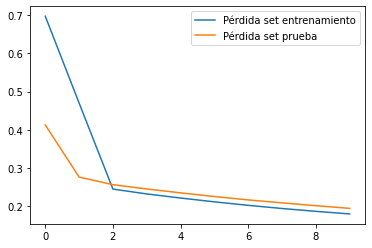

In [5]:
plt.plot(hist.history["loss"], label="Pérdida set entrenamiento")
plt.plot(hist.history["val_loss"], label="Pérdida set prueba")
plt.legend();

In [6]:
mnist = tf.keras.datasets.mnist
(X_mnist_train, Y_mnist_train), (mnist_validation_images, mnist_validation_labels) = mnist.load_data()

# Normalizo MNIST usando la media y el desvio anterior
mnist_validation_images = (mnist_validation_images - media)/desvio

W = np.concatenate((mnist_validation_images, validation_images))
#Z = np.concatenate((mnist_validation_labels, validation_labels))

11490434/11490434 [==============================] - 0s 0us/step


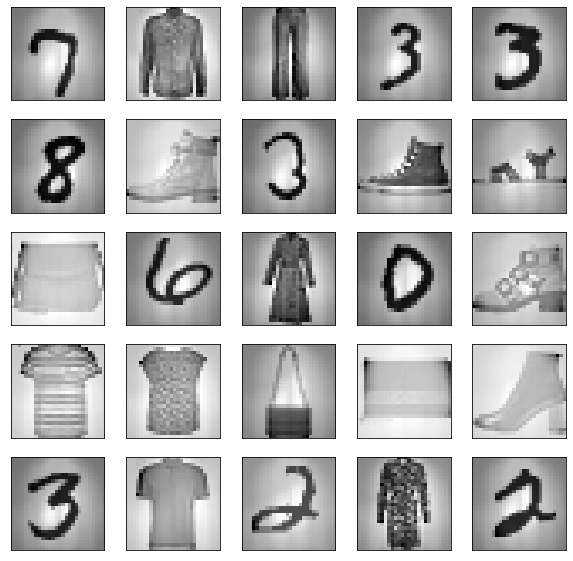

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  img_index = np.random.randint(0, W.shape[0])
  plt.imshow(W[img_index], cmap="gray_r")

In [ ]:
W.shape

(20000, 28, 28)

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay
images_predicted = model.predict(W)

625/625 [==============================] - 2s 2ms/step


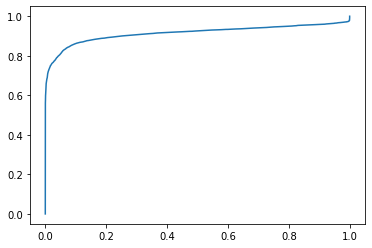

In [8]:
def rates(images_predicted, umbral_start, umbral_end, umbral_steps, ecm):
  # True Positive = la verdad es positiva, y la prediccion positiva
  # True Negative = la verdad es negativa, y la prediccion negativa
  # False Negative = la verdad es positiva, y la prediccion negativa
  # Falso Positivo = la verdad es negativa, y la prediccion positiva
  # False Positive Rate: FPR = FP/FP + TN
  # False Negative RAte: FNR = FN/FN + TP
  # True Positive RAte: TPR = TP/TP + FN
  # True Negative Rate: TNR = TN/TN + FP

  FPR = []
  FNR = []
  TPR = []
  TNR = []
  
  mask = np.full((20000), True)
  mask[0:10000] = False             # Mascara para indicar los que tienen False son anomalias 
  mask = mask.reshape(20000, 1)

  for i in np.arange(umbral_start, umbral_end, umbral_steps): # La mascara es la realidad y la comparacion es prediccion. No es anomalia => positivo
    TP = np.sum((ecm < i) & mask)           # TP = Aquellos cuyo ecm es menor al umbral y no son anomalias (True en la mascara)
    TN = np.sum((ecm >= i) & (mask == False))      
    FN = np.sum((ecm >= i) & mask)     
    FP = np.sum((ecm < i) & (mask == False))          

    FPR.append(FP/(FP + TN))
    FNR.append(FN/(FN + TP))
    TPR.append(TP/(TP + FN))
    TNR.append(TN/(TN + FP))

  return FPR, FNR, TPR, TNR

W = W.reshape(W.shape[0], 28 * 28)
images_predicted = images_predicted.reshape(images_predicted.shape[0], 28 * 28)
ec = np.sum((W - images_predicted )**2, axis = 1)
ec = ec.reshape(20000, 1)

FPR, FNR, TPR, TNR = rates(images_predicted, np.min(ec), np.max(ec), 1, ec)

# Sensibilidad: la probabilidad de que el modelo prediga un resultado positivo para una observación cuando en realidad el resultado es positivo. 
# Especificidad: La probabilidad de que el modelo prediga un resultado negativo para una observación cuando en realidad el resultado es negativo.

fig, ax = plt.subplots()
ax.plot(FPR, TPR)
plt.show()



In [9]:
# Equal Error Rate
k = np.argmin((np.subtract(FPR,FNR))**2)
err = FPR[k]
print(err)

0.1261


4) Obtenga los valores de las unidades de menor dimensión de su autoencoder tanto
para entrenamiento como para validación (FASHION-MNIST). Con ellos construya
una nueva base de datos y guarde los data-frames.

In [12]:
# Debo crear una base de datos con la salida de la capa oculta de dimensión 128 del modelo

# Defino nuevo modelo
encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.Input(shape=(28,28)))
encoder.add(tf.keras.layers.Flatten())
encoder.add(tf.keras.layers.Dense(n_hidden_units, activation='relu',kernel_initializer='GlorotNormal'))
encoder.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
Total params: 100,480
Trainable params: 100,480
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Recupero los pesos del primer modelo
encoder.set_weights(model.layers[1].get_weights())

# Guardo el modelo
encoder.save('./encoder.h5')

train_units = encoder.predict(train_images)
validation_units = encoder.predict(validation_images)


313/313 [==============================] - 1s 2ms/step


### Clasificación

CIFAR-10 (está en keras) contiene imágenes RGB de 32×32 (en total dimensión 3072)
para hacer clasificación de objetos. Las clases son

0	airplane
1	automobile
2	bird
3	cat
4	deer
5	dog
6	frog
7	horse
8	ship
9	truck

In [14]:
import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

170498071/170498071 [==============================] - 3s 0us/step


1) . Observar algunos ejemplos de imágenes de CIFAR. Una buena opción para ésto es
utilizar imshow de pyplot.

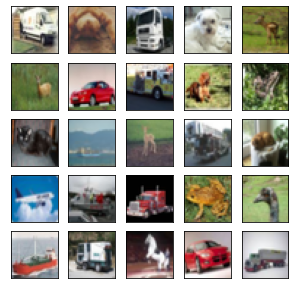

In [ ]:
plt.figure(figsize=(5,5))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  img_index = np.random.randint(0, x_train.shape[0])
  plt.imshow(x_train[img_index], cmap="gray_r")

2) Construir un clasificador utilizando la base de datos como entrenamiento/validación

In [15]:
import tensorflow as tf

# Aplico reshape
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2] * x_train.shape[3])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2] * x_test.shape[3])

# Normalización
x_train_media = np.mean(x_train,axis=0)
x_train_desvio = np.std(x_train,axis=0)
x_train = (x_train - x_train_media)/x_train_desvio

x_test_media = np.mean(x_test,axis=0)
x_test_desvio = np.std(x_test,axis=0)
x_test = (x_test - x_test_media)/x_test_desvio

# One hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [16]:
# Modelo
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(3072,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               786688    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 820,874
Trainable params: 820,874
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
hist = model.fit(x_train, y_train, epochs=30, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/30
391/391 [==============================] - 9s 21ms/step - loss: 1.8279 - accuracy: 0.3769 - val_loss: 1.6475 - val_accuracy: 0.4305
Epoch 2/30
391/391 [==============================] - 8s 21ms/step - loss: 1.5418 - accuracy: 0.4555 - val_loss: 1.5411 - val_accuracy: 0.4581
Epoch 3/30
391/391 [==============================] - 10s 26ms/step - loss: 1.4204 - accuracy: 0.5011 - val_loss: 1.5350 - val_accuracy: 0.4696
Epoch 4/30
391/391 [==============================] - 8s 20ms/step - loss: 1.3334 - accuracy: 0.5312 - val_loss: 1.5440 - val_accuracy: 0.4791
Epoch 5/30
391/391 [==============================] - 8s 20ms/step - loss: 1.2649 - accuracy: 0.5564 - val_loss: 1.4578 - val_accuracy: 0.4927
Epoch 6/30
391/391 [==============================] - 8s 20ms/step - loss: 1.2030 - accuracy: 0.5766 - val_loss: 1.5796 - val_accuracy: 0.4769
Epoch 7/30
391/391 [==============================] - 8s 20ms/step - loss: 1.1445 - accuracy: 0.5962 - val_loss: 1.5297 - val_accuracy: 0.493

3) Reportar el accuracy de validación.

El accuracy de validación es aproximadamente del 50%

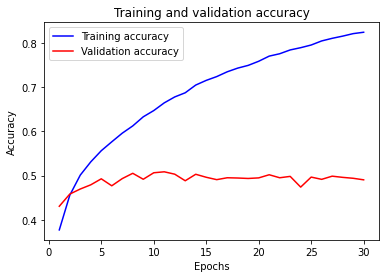

In [18]:
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

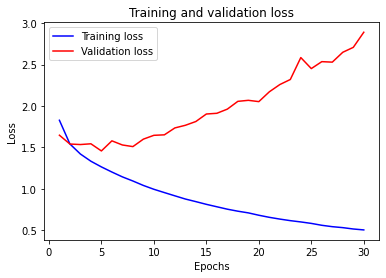

In [19]:
# grafica con la función de coste
 
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

En la gráfico vemos que a partir de la octava iteración (epoch), la función de coste sobre el conjunto de validación comienza a crecer (empeora), mientras que en el caso del conjunto de entrenamiento sigue decreciendo (mejorando). Eso es señal de que el modelo esta sobreentrenado (overfitting). 

Es decir, que predice muy bien en el conjunto de entrenamiento, pero mal en datos externos a este. Y eso es malo. Podemos hacer varias cosas para evitarlo, pero las dos más sencillas son, quitar neuronas para simplificar el modelo y/o reducir el número de iteraciones.

###Regresión 

El archivo "molinos.csv" contiene datos de potencias acumuladas por un parque eólico para los diferentes vientos. La columna "Velocity" contiene el módulo del viento en ese instante y la columnna "Direction" el ángulo de la velocidad medido en sentido horario ubicando el cero en vientos que provienen del norte. Finalmente las columnas "P" contiene las potencias acumuladas por cada molino.

In [24]:
import pandas as pd
dataset_molinos = pd.read_csv('https://github.com/CSC-CONICET/CURSO-LEARNING1/raw/main/datasets/molinos.csv')
dataset_molinos.head()

,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_9,P_10,...,P_36,P_37,P_38,P_39,P_40,P_41,P_42,P_43,Velocity,Direction
0,1324.1,1324.3,1330.0,1337.8,1338.1,1328.2,1229.8,1325.6,1256.1,1338.2,...,1296.6,1114.5,1238.1,1316.0,1299.9,1257.5,1138.4,1172.8,12.1,260.0
1,1497.4,1499.0,1499.1,1485.8,1435.6,1338.4,1273.5,1035.2,594.9,1495.0,...,1472.1,1395.8,1289.7,1416.0,1249.6,1114.5,802.1,679.2,10.8,254.0
2,1724.9,1750.3,1467.2,1317.3,1285.5,1178.1,989.0,798.8,376.6,1388.3,...,1370.0,1090.9,962.2,1148.0,1055.2,772.5,555.4,316.3,8.4,253.0
3,1594.7,1686.5,1394.2,1327.2,1247.6,1236.1,1170.3,889.0,255.9,1555.4,...,1185.4,1053.1,773.2,924.2,799.5,576.3,448.1,418.8,7.8,251.0
4,1645.4,1678.3,1537.7,1397.1,1403.9,1390.1,1278.6,654.6,181.3,1624.8,...,1335.1,1504.6,1014.5,1207.9,989.8,1030.7,906.8,816.2,7.8,248.0


In [25]:
dataset_molinos.shape

(128550, 45)

1) Curado de datos: Tirar todas las filas de datos donde haya alguna potencia negativa. Las mismas no tienen sentido, son simplemente errores de medición.

In [26]:
dataset = dataset_molinos[np.sum(dataset_molinos >= 0, axis = 1) == 45]

In [27]:
dataset.shape

(82737, 45)

2) Pasar las velocidades a coordenadas cartesianas

In [28]:
import math

def pasar_a_coordenadas_cartesianas(dataset):
  dataset = dataset.copy()
  dataset['Direction'] = ( dataset['Direction'] - 90 ) % 360

  cos_x = dataset['Direction'].apply(lambda x: math.cos(math.radians(x)))
  sin_y = dataset['Direction'].apply(lambda x: math.sin(math.radians(x)))
  comp_x = dataset['Velocity'] * cos_x
  comp_y = dataset['Velocity'] * sin_y

  dataset.drop(['Direction', 'Velocity'], axis = 1, inplace = True)

  dataset['Velocity_x'] = comp_x
  dataset['Velocity_y'] = -1 * comp_y
  return dataset

dataset = pasar_a_coordenadas_cartesianas(dataset)
dataset.head()

,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_9,P_10,...,P_36,P_37,P_38,P_39,P_40,P_41,P_42,P_43,Velocity_x,Velocity_y
317,1097.9,535.1,975.1,957.4,932.6,810.6,946.9,591.5,856.2,882.6,...,999.2,975.9,1033.2,1090.6,1217.2,1020.0,1230.3,1116.8,6.716915,-5.838925
318,859.6,487.0,1000.4,768.7,869.9,820.0,794.3,574.0,980.3,709.4,...,687.7,760.9,780.0,926.3,904.1,808.9,959.5,881.5,6.168102,-5.553784
319,766.7,413.2,767.1,650.9,838.7,828.6,732.5,487.3,723.9,588.3,...,730.5,773.6,838.0,820.6,898.3,905.3,978.0,961.8,6.114388,-5.904596
320,677.6,503.8,786.4,584.2,601.6,669.0,558.8,345.4,758.2,683.1,...,803.9,831.8,824.3,789.2,876.7,1006.7,853.3,899.3,5.704559,-5.319587
321,762.4,324.8,703.6,577.8,688.5,582.4,630.0,309.1,615.4,704.0,...,736.1,874.8,791.9,912.5,746.9,954.5,848.4,885.0,4.986049,-5.735793


3) Entrenar un regresor que estime la velocidad del viento (dos dimensiones cartesianas) en función de las potencias. Para ello separar los datos como crea conveniente.

In [29]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2)

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(43,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               11264     
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 2)                 258       
                                                                 
Total params: 44,418
Trainable params: 44,418
Non-trainable params: 0
_________________________________________________________________


In [30]:
x_train = train[train.columns[0:43]]
y_train = train[train.columns[-2:]]

# Normalizo x_train
x_train = (x_train - np.mean(x_train, axis = 0)) / np.std(x_train, axis = 0)

model.compile(optimizer=tf.keras.optimizers.Adam(),loss='MeanSquaredError')
hist = model.fit(x_train, y_train, batch_size = 128, epochs= 30) 

Epoch 1/30
518/518 [==============================] - 3s 4ms/step - loss: 19.8214
Epoch 2/30
518/518 [==============================] - 2s 4ms/step - loss: 15.4115
Epoch 3/30
518/518 [==============================] - 2s 4ms/step - loss: 14.0591
Epoch 4/30
518/518 [==============================] - 2s 4ms/step - loss: 13.2626
Epoch 5/30
518/518 [==============================] - 2s 4ms/step - loss: 12.9789
Epoch 6/30
518/518 [==============================] - 2s 4ms/step - loss: 12.6867
Epoch 7/30
518/518 [==============================] - 2s 4ms/step - loss: 12.4386
Epoch 8/30
518/518 [==============================] - 2s 4ms/step - loss: 12.2175
Epoch 9/30
518/518 [==============================] - 2s 4ms/step - loss: 12.1043
Epoch 10/30
518/518 [==============================] - 3s 5ms/step - loss: 11.9294
Epoch 11/30
518/518 [==============================] - 3s 6ms/step - loss: 11.7757
Epoch 12/30
518/518 [==============================] - 3s 6ms/step - loss: 11.7376
Epoch 13/30
5

4) Crear una script que levante el modelo entrenado y permita probarlo. Tiene que
devolver el error cuadrático medio (básicamente esto signica que hay un set de
datos que no les paso que lo voy a usar para probar su algoritmo). Tenga en cuenta
que el formato de los datos será el mismo que este dataset (módulo y fase en sentido
horario con respecto al viento del norte).

In [32]:
model_json = model.to_json()
with open('model_molinos.json','w') as json_file:
  json_file.write(model_json)

model.save_weights('modelo_molinos.h5',save_format='h5')

In [33]:
json_file_loaded = open('model_molinos.json','r')
loaded_model_json = json_file_loaded.read()
loaded_model_h5 = tf.keras.models.model_from_json(loaded_model_json)
loaded_model_h5.load_weights('modelo_molinos.h5')
modelo = loaded_model_h5

def ecm(dataset):
  modelo = pasar_a_coordenadas_cartesianas(modelo)
  x_train = modelo[dataset.columns[0:43]]
  y_train = modelo[dataset.columns[-2:]]

  x_train = (x_train - np.mean(x_train, axis = 0)) / np.std(x_train, axis = 0)

  y_predicted = modelo.predict(x_train)

  ecm = np.sum((y_predicted - y_train) ** 2) / len(x_train)

  return ecm
